In [160]:
#imports
import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows',None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth',0)
pd.options.mode.chained_assignment = None  # default='warn'
import unicodedata

from pandas import DataFrame

import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
np.set_printoptions(threshold='nan')

import math
from __future__ import division

import os

In [161]:
df = pd.read_csv('train.tsv',sep='\t',encoding="utf-8")

good = df[df["Label"]==1]    #good
bad = df[df["Label"]==2]    #bad

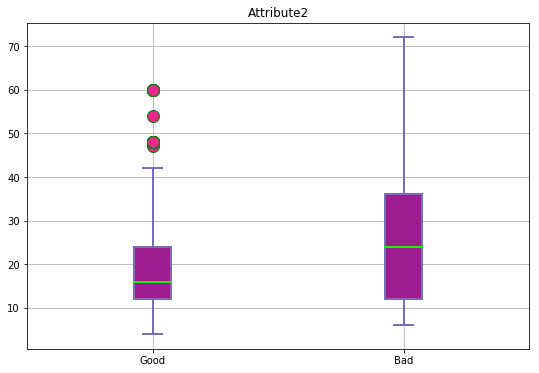

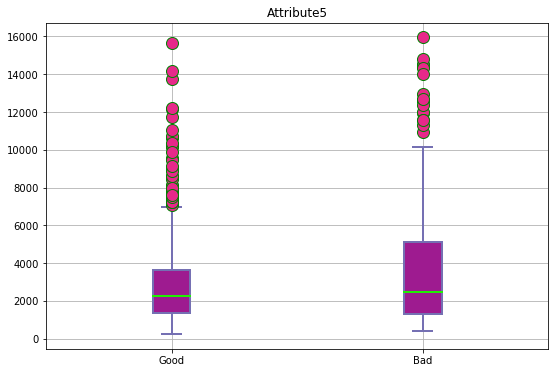

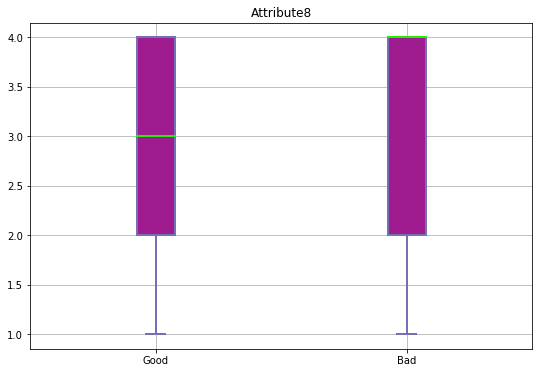

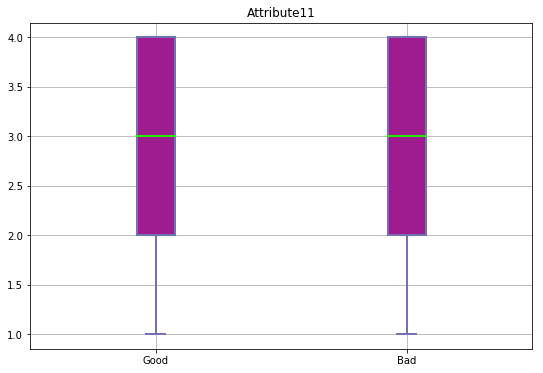

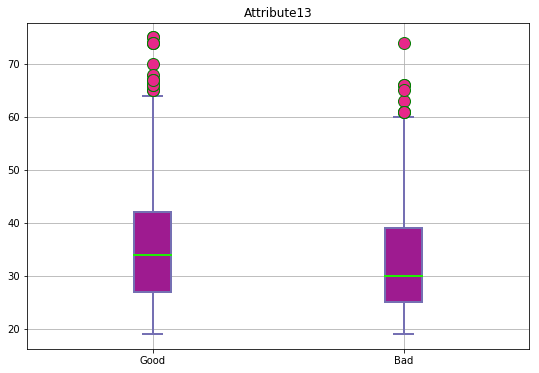

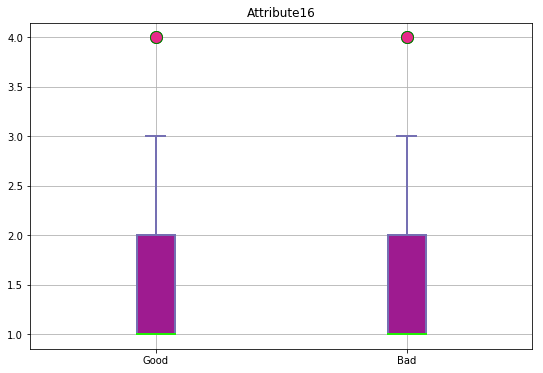

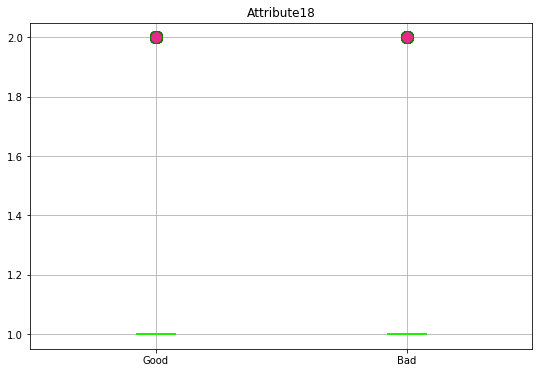

In [162]:
#Numerical data box plot
Attributes = ["Attribute2","Attribute5","Attribute8","Attribute11","Attribute13","Attribute16","Attribute18"]

for attribute in Attributes:
    
    Attribute_good = good[[attribute]]
    Attribute_bad = bad[[attribute]]
    
    #convert data into list
    Attribute2_good = list(Attribute_good.values.flatten())
    Attribute2_bad = list(Attribute_bad.values.flatten())
    
    
    data_to_plot = [Attribute2_good, Attribute2_bad]

    # Create a figure instance
    fig = plt.figure(1, figsize=(9, 6))

    # Create an axes instance
    ax = fig.add_subplot(111)


    # Create the boxplot
    ## change the style of fliers and their fill
    flierprops = dict(marker='o', markerfacecolor='#e7298a', markersize=12,
                  linestyle='none', markeredgecolor='g') 
    
    #Create the boxplot
    bp = ax.boxplot(data_to_plot, patch_artist=True, flierprops= flierprops)
    
    #Change color

    ## change outline color, fill color and linewidth of the boxes
    for box in bp['boxes']:
        # change outline color
        box.set( color='#7570b3', linewidth=2)
        # change fill color
        box.set( facecolor = '#9e1b90' )

    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(color='#7570b3', linewidth=2)

    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='#7570b3', linewidth=2)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='#20ef04', linewidth=2)
           

    #Set grid
    ax.grid()

    #Set labels
    ax.set_xticklabels(['Good', 'Bad'])    

    #Set title
    plt.title(attribute)
    
    figBox = plt.gcf()
    plt.show()

    # Save figure
    path = 'Output/Box Plots/'
    if not os.path.isdir(path): os.makedirs(path)
    filename = 'box_plot%s.png' % attribute
    filename = os.path.join(path, filename)
    figBox.savefig(filename)

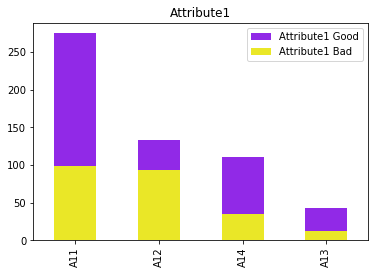

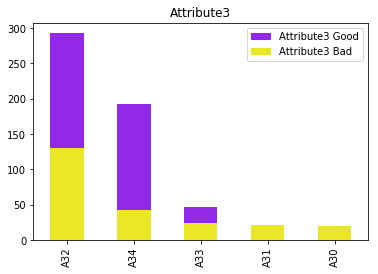

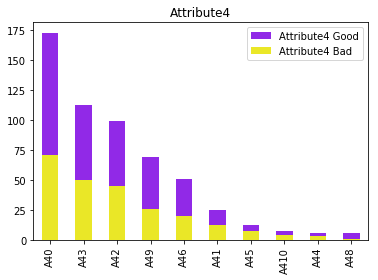

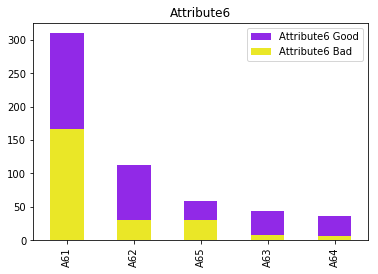

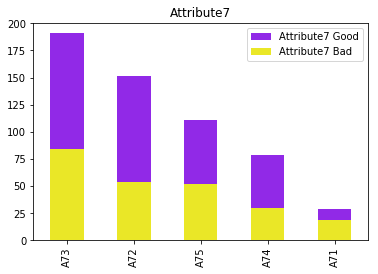

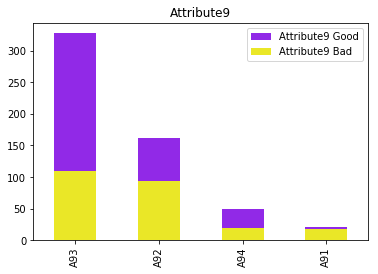

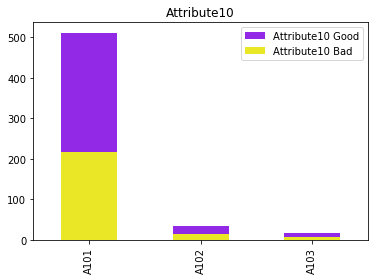

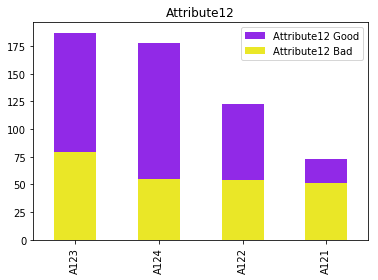

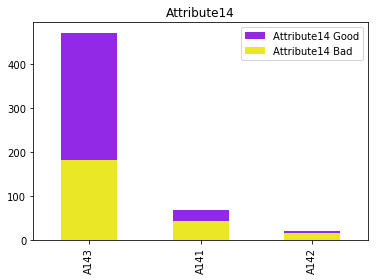

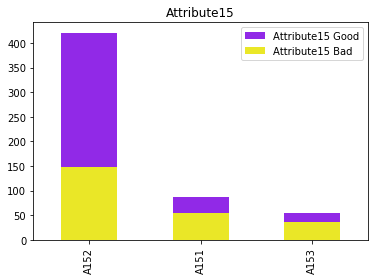

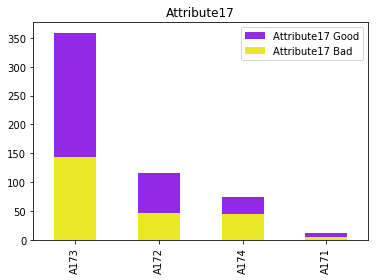

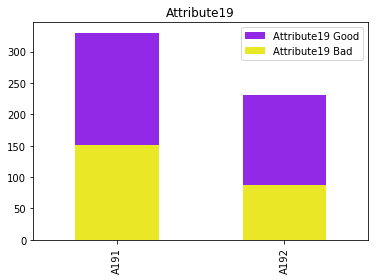

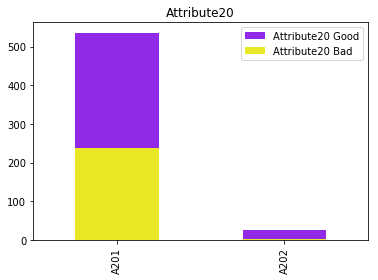

In [163]:
#categorical data histograms
attributesCategorical = ['Attribute1','Attribute3','Attribute4','Attribute6','Attribute7','Attribute9','Attribute10'
              ,'Attribute12','Attribute14','Attribute15','Attribute17','Attribute19','Attribute20']

for item in attributesCategorical:

    attributeGood = pd.Series(good[item])
    attributeBad = pd.Series(bad[item])
    stringGood = item + " Good"
    stringBad = item + " Bad"

    plt.title(item)
    attributeGood.value_counts().plot(kind='bar',label= stringGood, color = '#9129e7' )
    attributeBad.value_counts().plot(kind='bar',label= stringBad, color = '#eae727')
    plt.legend()
    
    figHist = plt.gcf()
    plt.show()
    
    # Save figure
    path = 'Output/Histogram Plots/'
    if not os.path.isdir(path): os.makedirs(path)
    filename = 'hist_plot%s.png' % item
    filename = os.path.join(path, filename)
    figHist.savefig(filename)

In [164]:
#preprocessing data

from sklearn import preprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

le = preprocessing.LabelEncoder()

withoutLabel = df.ix[:, df.columns != 'Label' ]
withoutLabelAndId = withoutLabel.ix[:, withoutLabel.columns != 'Id' ]
withoutLabelAndIdCategoricals = withoutLabelAndId[attributesCategorical]


Count_Row = withoutLabelAndId.shape[0]

TransformedCategoricals = withoutLabelAndIdCategoricals.apply(le.fit_transform)

withoutLabelAndId.update(TransformedCategoricals)


listOfDocuments= []
for i in range(Count_Row):
    documents = withoutLabelAndId.iloc[i]
    documents = documents.to_string(index=False , header = False).encode('utf8')
    listOfDocuments.append(documents)
    
    
tupleOfDocuments = tuple(listOfDocuments)


tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(tupleOfDocuments)

#SVD
tfidf_matrix = np.array(TruncatedSVD(n_components=10).fit_transform(tfidf_matrix))

In [165]:
#creating y for classification
X = np.array(tfidf_matrix)

y = []
for i in range(Count_Row):
    y.append(df["Label"].iloc[i]) 
    
y = np.array(y)

In [166]:
#classification
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import *

random_state = np.random.RandomState(0)
k_fold = KFold(n_splits=10,shuffle = True)

#svm
clf = SVC(gamma=100, C=10)
clf.fit(X, y)
accuracySVM = cross_val_score(clf, X, y, cv=k_fold, n_jobs=-1 , scoring = 'accuracy')
accuracyMeanSVM =np.mean(accuracySVM)

#random forest
clf = RandomForestClassifier(n_estimators=80)
clf.fit(X, y)
accuracyRF = cross_val_score(clf, X, y, cv=k_fold, n_jobs=-1 , scoring = 'accuracy')
accuracyMeanRF =np.mean(accuracyRF)

#naive bayes
clf = GaussianNB()
clf.fit(X, y)
accuracyNB = cross_val_score(clf, X, y, cv=k_fold, n_jobs=-1 , scoring = 'accuracy')
accuracyMeanNB =np.mean(accuracyNB)

In [167]:
#creating csv file for accuracy
import csv

with open('Output/EvaluationMetric_10fold.csv', 'wb') as fp:
    writer = csv.writer(fp, delimiter='\t') 
    l = [(' ','Statistic Measure', 'Naive Bayes', 'Random Forest', 'SVM'),
         (' ','Accuracy', accuracyMeanNB, accuracyMeanRF, accuracyMeanSVM)]
    writer.writerows(l)
    
evalDf = pd.read_csv('Output/EvaluationMetric_10fold.csv',sep='\t',encoding="utf-8",index_col=0)
evalDf

,Statistic Measure,Naive Bayes,Random Forest,SVM
,,,,
,Accuracy,0.67125,0.6225,0.64


In [168]:
#removing id from df
dfTest = pd.read_csv('test.tsv',sep='\t',encoding="utf-8")

withoutId = dfTest.ix[:, dfTest.columns != 'Id' ]

In [169]:
#figuring out categories for testSet

Count_RowTest = dfTest.shape[0]

withoutIdCategoricals = withoutId[attributesCategorical]

TransformedCategoricalsWithoutId = withoutIdCategoricals.apply(le.fit_transform)
withoutId.update(TransformedCategoricalsWithoutId)

listOfDocumentsTest= []
IdList = []
for i in range(Count_RowTest):
    documents = withoutId.iloc[i]
    IdList.append(dfTest['Id'].iloc[i])
    documents = documents.to_string(index=False , header = False).encode('utf8')
    listOfDocumentsTest.append(documents)
    
tupleOfDocumentsTest = tuple(listOfDocumentsTest)    

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrixTest = tfidf_vectorizer.fit_transform(tupleOfDocumentsTest)

#SVD
tfidf_matrixTest = np.array(TruncatedSVD(n_components = 10).fit_transform(tfidf_matrixTest))


clf = GaussianNB()
clf.fit(X, y)

categories = clf.predict(tfidf_matrixTest)

TestList = []

for i in range(len(categories)):
    if (categories[i]==1):
         TestList.append("Good")
    elif (categories[i]==2):
         TestList.append("Bad")

FinalTestList = zip(IdList, TestList)

with open('Output/testSet_Predictions.csv', 'wb') as fp:
    writer = csv.writer(fp, delimiter='\t') 
    l = [(' ','Client_ID', 'Predicted_Label')]
    
    for item in FinalTestList:
        l.append((' ',item[0],item[1]))
         
    writer.writerows(l)
    
dfPredict = pd.read_csv('Output/testSet_Predictions.csv',sep='\t',encoding="utf-8",index_col=0)
dfPredict    


,Client_ID,Predicted_Label
,,
,10902,Bad
,10903,Good
,10904,Good
,10905,Good
,10906,Good
,10907,Good
,10908,Good
,10909,Good
,10910,Good


In [170]:
#my function for entropy
def entropy(num1,num2):
    a = num1/(num1+num2)
    b = num2/(num1+num2)
    mathem = -a*math.log(a,2) -b*math.log(b,2)
    return mathem

In [171]:
#calculating parent Entropy
Count_Row = df.shape[0]
labelFeature = df['Label']

counts = np.array(labelFeature.value_counts());
parentEntropy = entropy(counts[0],counts[1])

In [172]:
#calculating information gain for categorical data
attributesCategorical = ['Attribute1','Attribute3','Attribute4','Attribute6','Attribute7','Attribute9','Attribute10'
              ,'Attribute12','Attribute14','Attribute15','Attribute17','Attribute19','Attribute20']

infoGain = []
for attribute in attributesCategorical:   
    
    rating_probs = df.groupby(attribute).size().div(len(df))
   
    probabilities = []
     
    for k,v in rating_probs.iteritems():
        if v>0:
            probabilities.append((k,v))
            
    a = df.groupby([attribute,'Label']).size()

    keys = list([a.keys()[x][0] for x in range(len(a.keys()))])

    values = list([i for i in a])

    allVal = zip(keys,values)

    terms =[]

    r = zip(allVal,allVal[1:])[::2]
    
    counter=0
   
    for i in r:
        
        entr1 = entropy(i[0][1],i[1][1])
        result = probabilities[counter][1]*entr1
        terms.append(result)
        counter+=1

    entropyAttr = sum(terms)
    numAttribute = attribute.replace('Attribute', '')  #for sorting
    numAttribute = int(numAttribute)


    infoGain.append(((parentEntropy - entropyAttr),numAttribute))

In [173]:
#calculating information gain for numerical data
AttributesNumerical = ["Attribute2","Attribute5","Attribute8","Attribute11","Attribute13","Attribute16","Attribute18"]
group_names = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

for attribute in AttributesNumerical:  
     
    feature = df[attribute]
    attributeCut = pd.cut(feature, 5, labels = group_names)  #binning numerical data

    d = {attribute : pd.Series(attributeCut),
            'Label' : pd.Series(df['Label'])}

    d = pd.DataFrame(d) 


    a = d.groupby([attribute,'Label']).size()  

    rating_probs = d.groupby(attribute).size().div(len(d))

    
    probabilities = []
    
    
    for k,v in rating_probs.iteritems():
        if v>0:
            probabilities.append((k,v))


    keys = list([a.keys()[x][0] for x in range(len(a.keys()))])

    values = list([i for i in a])

    allVal = zip(keys,values)

    terms =[]

    r = zip(allVal,allVal[1:])[::2]

    
    for i in range(len(r)):

        entr2 = entropy(r[i][0][1],r[i][1][1])
        result = probabilities[i][1]*entr2

        terms.append(result)


    entropyAttr = sum(terms)
    
    numAttribute = attribute.replace('Attribute', '')  #for sorting
    numAttribute = int(numAttribute)

    infoGain.append(((parentEntropy - entropyAttr),numAttribute))

In [174]:
sortInfoGain = sorted(infoGain, key=lambda x: x[1])
sortInfoGainValue = sorted(infoGain, key=lambda x: x[0])

setAttr = []
for x in range(len(sortInfoGainValue)):
    string = str(sortInfoGainValue[x][1])
    finalstring = string.replace(string,"Attribute"+string)
    setAttr.append(finalstring) 

setAttr = setAttr[:-1]  #all but the last attribute

In [175]:
#accuracy and attributes graph
dfAttr = pd.read_csv('train.tsv',sep='\t',encoding="utf-8")

dfAttr = dfAttr.ix[:, dfAttr.columns != 'Id' ]
dfAttr = dfAttr.ix[:, dfAttr.columns != 'Label' ]

withoutIdAndLabelCategoricals = dfAttr[attributesCategorical]

TransformedCategoricalsWithoutIdAndLabel = withoutIdAndLabelCategoricals.apply(le.fit_transform)
dfAttr.update(TransformedCategoricalsWithoutIdAndLabel)

accuracyMeanList = []

for attribute in setAttr:

    dfAttr = dfAttr.ix[:, dfAttr.columns != attribute ]
    dfAttr = dfAttr.ix[:, dfAttr.columns != attribute ]

    Count_RowAttr = dfAttr.shape[0]

    listOfDocumentsAttr= []
    for i in range(Count_RowAttr):
        documents = dfAttr.iloc[i]
        documents = documents.to_string(index=False , header = False).encode('utf8')
        listOfDocumentsAttr.append(documents)


    tupleOfDocumentsAttr = tuple(listOfDocumentsAttr)


    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrixAttr = tfidf_vectorizer.fit_transform(tupleOfDocuments)

    #SVD
    tfidf_matrixAttr = np.array(TruncatedSVD(n_components=10).fit_transform(tfidf_matrixAttr))

    X = np.array(tfidf_matrixAttr)
    y = []
    for i in range(Count_RowAttr):
        y.append(df["Label"].iloc[i]) 


    y = np.array(y)

    k_fold = KFold(n_splits=10,shuffle = True)

    clf = GaussianNB()
    clf.fit(X, y)
    accuracyNB = cross_val_score(clf, X, y, cv=k_fold, n_jobs=-1 , scoring = 'accuracy')
    accuracyMeanNB =np.mean(accuracyNB)
    accuracyMeanList.append(accuracyMeanNB)

print "Accuracy"
print accuracyMeanList    

Accuracy
[0.66125, 0.66999999999999993, 0.65500000000000003, 0.65250000000000008, 0.66375000000000006, 0.65749999999999997, 0.67499999999999993, 0.6712499999999999, 0.66500000000000004, 0.66874999999999996, 0.66249999999999998, 0.65999999999999992, 0.67374999999999996, 0.65749999999999997, 0.66500000000000004, 0.65749999999999997, 0.66124999999999989, 0.66874999999999996, 0.66249999999999987]


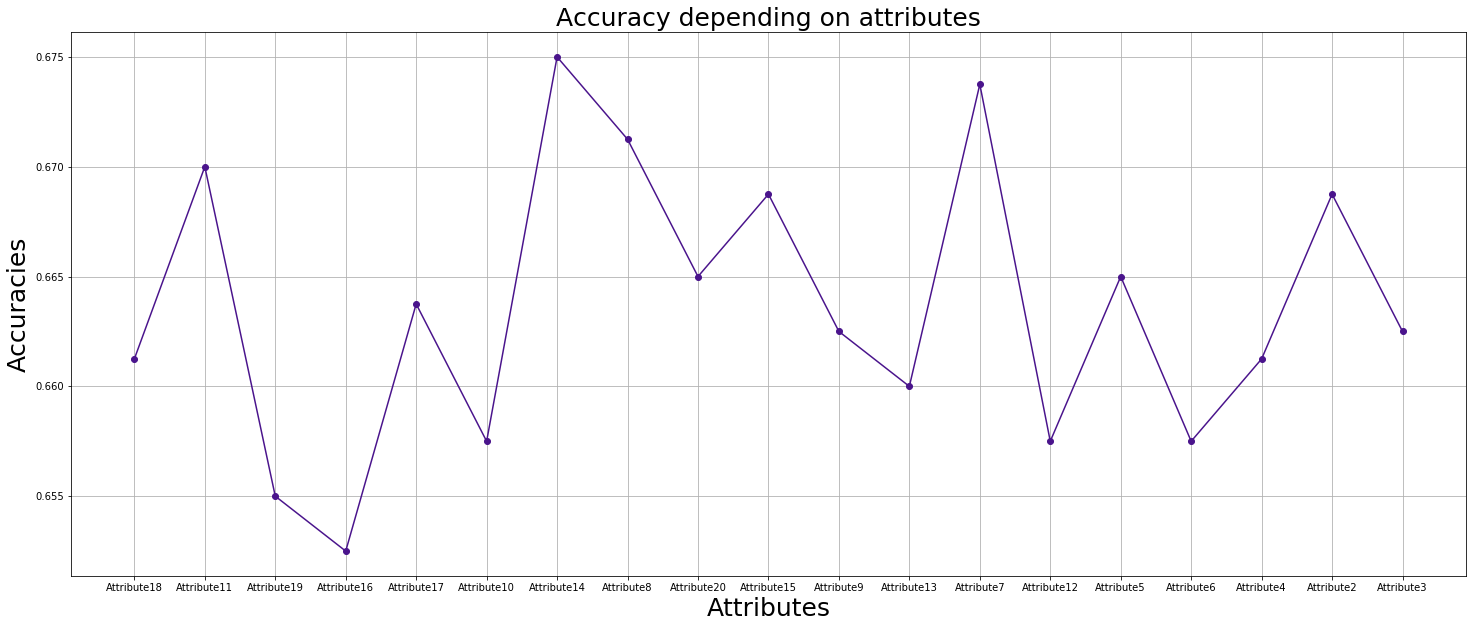

In [176]:
#plot for accuracy depending on attribute
plt.figure(figsize=(25,10))
x = range(len(accuracyMeanList))
plt.xticks(x, setAttr)

plt.plot(x,accuracyMeanList, marker='o',color='#4A148C')


plt.xlabel('Attributes',size = 25)
plt.ylabel('Accuracies',size = 25)
plt.title('Accuracy depending on attributes',size = 25)
plt.grid(True)

figAccur = plt.gcf()

plt.show()

# Save figure
path = 'Output/'
if not os.path.isdir(path): os.makedirs(path)
filename = 'accuraciesAttributes.png'
filename = os.path.join(path, filename)
figAccur.savefig(filename)

plt.clf()
plt.cla()
plt.close()

In [177]:
#creating csv for attributes and information gain
with open('Output/infoGain.csv', 'wb') as fp:
    writer = csv.writer(fp, delimiter='\t') 
    l = [(' ','Attributes', 'Information Gain')]
    
    for x in range(len(sortInfoGainValue)):
        string = str(sortInfoGainValue[x][1])
        finalstring = string.replace(string,"Attribute"+string)
        l.append((' ',finalstring,sortInfoGainValue[x][0]))
         
    writer.writerows(l)
    
dfinfo = pd.read_csv('Output/infoGain.csv',sep='\t',encoding="utf-8",index_col=0)
dfinfo

,Attributes,Information Gain
,,
,Attribute18,0.000130
,Attribute11,0.000221
,Attribute19,0.001203
,Attribute16,0.002396
,Attribute17,0.002940
,Attribute10,0.005674
,Attribute14,0.007042
,Attribute8,0.007331
,Attribute20,0.007704
